The notebook contains three ML models for landslide susceptibility mapping: Random Forest (RF), Logistic Regression (LR) and Support Vector Machine (SVM) without climate variables (Predictor Set I)

In [ ]:
from pyspatialml import Raster
import os
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import seaborn as sn
import rasterio.plot
import numpy as np
import matplotlib as mpl
import os
import geopandas as gpd
import numpy as np
from tempfile import NamedTemporaryFile
import warnings
warnings.filterwarnings('ignore')

Setting up the working directory:

In [ ]:
os.chdir(r'C:\Users\aageen17\Desktop\Variables')

Loading the preprocessed landslide presence/absebce points

In [ ]:
data=pd.read_csv('data_final.csv')

In [ ]:
data.head()

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,slope_std,distance_coast,distance_streams,average_temp_ref,cloudburst_ref,groundwater_ref,rain_average_ref,rain_max_day_ref,soil,geomorphology,underground,prequaternary,class
0,15.706318,4.440497,0.126874,0.173688,-1.667908,0.196570,-0.980490,4.752529,115.0,300.0,8.462731,0.332363,-8.441628,2.006541,33.681606,15.0,7.0,3.0,6.0,1
1,15.232349,3.427183,0.048178,0.395249,0.731700,0.575379,-0.817887,3.343206,52.0,300.0,8.462731,0.332363,-1.949753,2.006541,33.681606,15.0,7.0,3.0,6.0,1
2,17.030214,3.888671,-0.000931,0.361396,1.081142,0.634705,-0.772755,0.880331,80.0,300.0,8.462731,0.332363,-1.608266,2.006541,33.681606,15.0,7.0,3.0,6.0,1
3,15.583941,4.675134,-0.030232,0.183543,0.294679,-0.788825,-0.614618,3.459515,120.0,300.0,8.455420,0.329927,-7.234321,2.017731,33.668327,15.0,7.0,3.0,6.0,1
4,17.499943,8.491714,0.150789,0.410609,5.817518,0.268115,-0.963387,2.392220,89.0,300.0,8.463237,0.328551,-0.485680,2.021318,33.706505,15.0,7.0,3.0,6.0,1


In [ ]:
data.describe()

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,slope_std,distance_coast,distance_streams,average_temp_ref,cloudburst_ref,groundwater_ref,rain_average_ref,rain_max_day_ref,soil,geomorphology,underground,prequaternary,class
count,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,36.904285,5.685200,-0.007074,0.290398,1.108998,0.126452,-0.187246,1.962083,218.364238,262.715232,8.402151,0.336105,-2.452514,2.093118,33.759074,14.227373,6.727373,1.984547,6.477925,0.500000
std,28.037540,2.188128,0.113616,0.285938,2.194177,0.665740,0.711890,1.988085,123.072533,78.458002,0.100797,0.004990,3.745274,0.120013,0.206058,2.410190,1.607187,0.614542,1.249114,0.500276
min,-0.063328,1.392764,-0.590734,0.007468,-4.570874,-0.999999,-0.999999,0.034482,2.000000,2.000000,8.208788,0.326009,-36.648720,1.897057,33.206406,1.000000,1.000000,1.000000,2.000000,0.000000
25%,8.646569,4.082074,-0.032213,0.066225,-0.416696,-0.451637,-0.877404,0.369370,50.000000,300.000000,8.319777,0.332142,-2.353362,2.004569,33.640068,15.000000,7.000000,2.000000,6.000000,0.000000
50%,33.112755,5.254739,-0.001261,0.205904,1.099958,0.224183,-0.370327,1.410287,300.000000,300.000000,8.414956,0.335395,-1.090938,2.073241,33.768017,15.000000,7.000000,2.000000,7.000000,0.500000
75%,61.300445,6.829001,0.024791,0.429368,2.347241,0.751924,0.508095,3.010567,300.000000,300.000000,8.473519,0.339699,-0.777830,2.210141,33.871841,15.000000,7.000000,2.000000,7.000000,1.000000
max,101.406158,19.239317,0.551858,1.812488,11.650669,0.999996,0.999999,12.869604,300.000000,300.000000,8.588979,0.351216,0.000000,2.304369,34.549335,20.000000,10.000000,3.000000,9.000000,1.000000


Dropping columns with climate data

In [ ]:
data= data.drop(columns=['average_temp_ref', 'cloudburst_ref', 'groundwater_ref', 'rain_average_ref', 'rain_max_day_ref'])

In [ ]:
predictors =['dem_elevation.tif', 'TWI.tif', 'TPI.tif', 'TRI.tif', 'SPI.tif', 'easterness.tif', 'northerness.tif', 'slope_std.tif',  'distance_coast.tif', 'distance_streams.tif', 'soil.tif', 'geomorphology.tif', 'underground.tif', 'prequaternary.tif']

making a raster stack out of predictors

In [ ]:
stack = Raster(predictors)

In [ ]:
stack.names

dict_keys(['dem_elevation', 'TWI', 'TPI', 'TRI', 'SPI', 'easterness', 'northerness', 'slope_std', 'distance_coast', 'distance_streams', 'soil', 'geomorphology', 'underground', 'prequaternary'])

Plotting variables

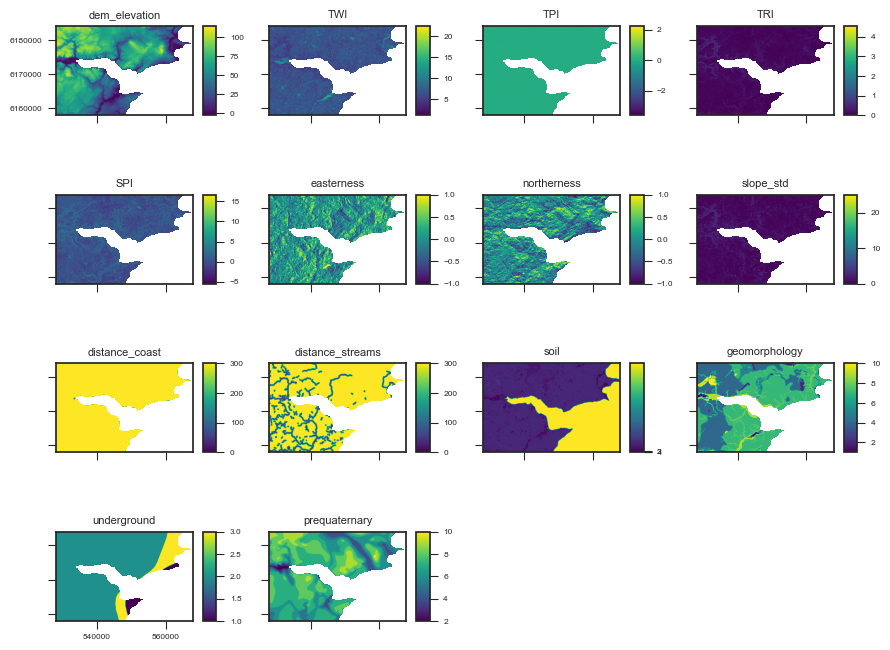

In [ ]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

In [ ]:
#stack = stack.intersect() - if variables have different extent

Importing packages for Machine Learning

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [ ]:
soil_idx = list(stack.names).index("soil")
geomorphology_idx = list(stack.names).index("geomorphology")
underground_idx = list(stack.names).index("underground")
prequaternary_idx = list(stack.names).index("prequaternary")
print(soil_idx, geomorphology_idx, underground_idx, prequaternary_idx)

10 11 12 13


In [ ]:
#index of categorical features from the dataset
categorical_features = [10, 11, 12, 13] # 'soil', 'geomorphology', 'underground', 'prequarternary'

In [ ]:
#index of numerical features from the dataset
numerical_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]   #'dem_elevation', 'TWI', 'TPI', 'TRI', 'SPI', 'easterness', 'northerness', 'slope_std', 'distance_coast', 'distance_streams'

In [ ]:
preprocessor = ColumnTransformer([
    ('ohe_soil', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)])

Separating features from class labels

In [ ]:
X = data.loc[:, stack.names]

In [ ]:
X[:3]

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,slope_std,distance_coast,distance_streams,soil,geomorphology,underground,prequaternary
0,15.706318,4.440497,0.126874,0.173688,-1.667908,0.196570,-0.980490,4.752529,115.0,300.0,15.0,7.0,3.0,6.0
1,15.232349,3.427183,0.048178,0.395249,0.731700,0.575379,-0.817887,3.343206,52.0,300.0,15.0,7.0,3.0,6.0
2,17.030214,3.888671,-0.000931,0.361396,1.081142,0.634705,-0.772755,0.880331,80.0,300.0,15.0,7.0,3.0,6.0


Our labels

In [ ]:
y = data["class"]

In [ ]:
y[:3]

0    1
1    1
2    1
Name: class, dtype: int64

Splitting our data into a training (70% of the data) and a testing set (30%), stratified after classes, so that we get the same amount of landslide and non-landslide samples in both sets. Random_sate= 42 for reproducebility

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Checking the number of points in testing and training data

In [ ]:
X_train.shape

(634, 14)

In [ ]:
X_test.shape

(272, 14)

## Random Forest model

In [ ]:
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

In [ ]:
# Create the  grid for hyperparametertuning
grid_rf = {'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400],
           'classifier__max_features': ['auto', 'sqrt', 'log2']}
print(grid_rf)

{'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400], 'classifier__max_features': ['auto', 'sqrt', 'log2']}


In [ ]:
# Create a classifier
rf = RandomForestClassifier(random_state=42)

 "Pipeline" is for making workflow with standardization and classification in a few lines of code

In [ ]:
rf_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', rf)
])

In [ ]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import GridSearchCV

In [ ]:
# Instantiate the grid search model with 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
model_rf = GridSearchCV(rf_flow, param_grid = grid_rf, cv = kfold, scoring=acc_scorer)

In [ ]:
model_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('ohe_soil',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [10,
                                                                          11,
                                                                          12,
                                                                          13]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                       

Best parameters from the grid search

In [ ]:
model_rf.best_params_

{'classifier__max_features': 'auto', 'classifier__n_estimators': 100}

Using the test data for prediction

In [ ]:
y_pred_rf = model_rf.predict(X_test)

Printing classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.93      0.88      0.91       136
    landslide       0.89      0.93      0.91       136

     accuracy                           0.91       272
    macro avg       0.91      0.91      0.91       272
 weighted avg       0.91      0.91      0.91       272



Printing confusion matrix

In [ ]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix
print(confusion_matrix(y_test, y_pred_rf))

[[120  16]
 [  9 127]]


Doing it in a better visual way

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

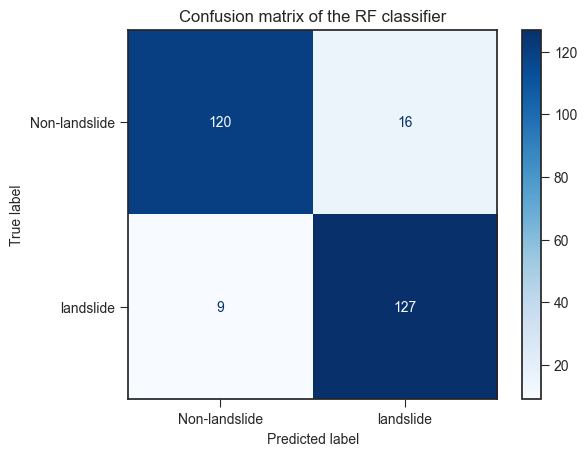

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the RF classifier')
plt.show()

Printing overall accuracy (all the correctly classified samples divided by the total number of samples)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_rf))

0.9080882352941176


Checking how our model is different from a classification created by a random process

In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred_rf))

0.8161764705882353


Plotting ROC_AUC

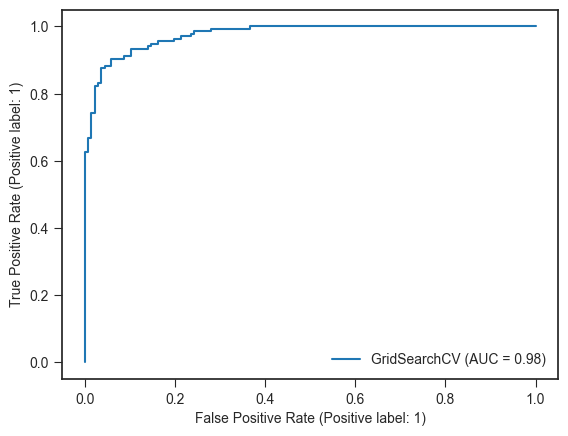

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve

metrics.plot_roc_curve(model_rf, X_test, y_test)  
plt.show() 

## Support Vector Machine model

In [ ]:
from sklearn.svm import SVC

In [ ]:
param_grid_SVM = [
  {'classifier__C': [0.001, 0.1, 1, 10], 'classifier__gamma': [1, 0.1, 0.01,0.001, 0.0001, 'scale', 'auto'], 'classifier__kernel': ['rbf']},
 ]


In [ ]:
# Create a model
svm = SVC(probability=True, random_state=42)

svm_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', svm)
])

# Instantiate the grid search model with 10-fold cross-validation
inner = KFold(n_splits=10, shuffle=True, random_state=42)
model_svm = GridSearchCV(svm_flow, param_grid = param_grid_SVM, cv = inner, scoring=acc_scorer)


# Fit the grid search to the data
model_svm.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('ohe_soil',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [10,
                                                                          11,
                                                                          12,
                                                                          13]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                       

In [ ]:
model_svm.best_params_

{'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}

In [ ]:
y_pred_svm = model_svm.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_svm, target_names = ['non-landslide', 'landslide']))


               precision    recall  f1-score   support

non-landslide       0.92      0.92      0.92       136
    landslide       0.92      0.92      0.92       136

     accuracy                           0.92       272
    macro avg       0.92      0.92      0.92       272
 weighted avg       0.92      0.92      0.92       272



In [ ]:
print(accuracy_score(y_test, y_pred_svm))

0.9191176470588235


In [ ]:
print(cohen_kappa_score(y_test, y_pred_svm))

0.8382352941176471


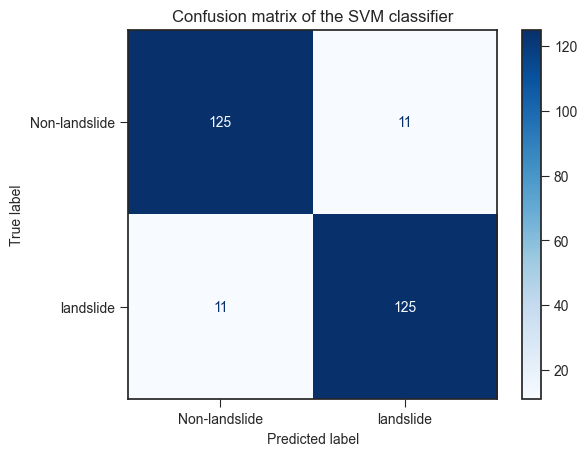

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the SVM classifier')
plt.show()

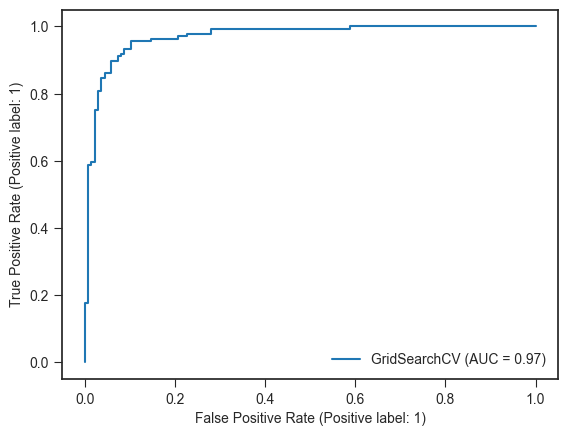

In [ ]:
metrics.plot_roc_curve(model_svm, X_test, y_test)  
plt.show() 

## Logistic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid_lr = [
  {'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'classifier__solver': ['liblinear'], 'classifier__penalty': ['l1','l2']},
  {'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'classifier__solver': ['lbfgs'], 'classifier__penalty': ['l2']},
 ]

In [ ]:
lr = LogisticRegression(random_state=42) 
# Instantiate the grid search model

lr_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', lr)
])

# Instantiate the grid search model with 10-fold cross-validation
model_lr = GridSearchCV(lr_flow, param_grid = param_grid_lr, cv = inner, scoring=acc_scorer)


# Fit the grid search to the data
model_lr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('ohe_soil',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [10,
                                                                          11,
                                                                          12,
                                                                          13]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                       

In [ ]:
model_lr.best_params_

{'classifier__C': 1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

Creating the final LR classifier with the found hyperparameters

In [ ]:
y_pred_lr = model_lr.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_lr, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.92      0.90      0.91       136
    landslide       0.91      0.93      0.92       136

     accuracy                           0.92       272
    macro avg       0.92      0.92      0.92       272
 weighted avg       0.92      0.92      0.92       272



In [ ]:
round(accuracy_score(y_test, y_pred_lr), 4)

0.9154

In [ ]:
print(cohen_kappa_score(y_test, y_pred_lr))

0.8308823529411764


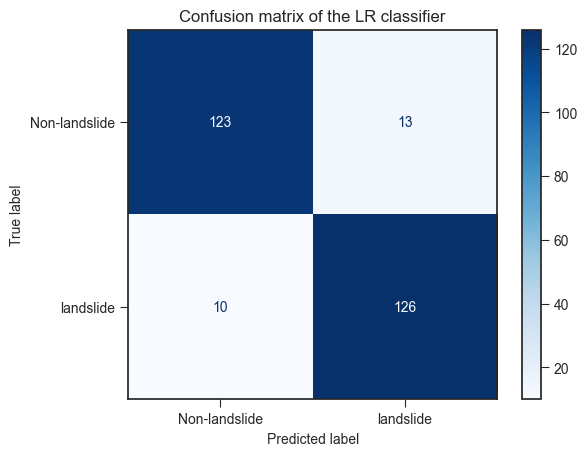

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the LR classifier')
plt.show()

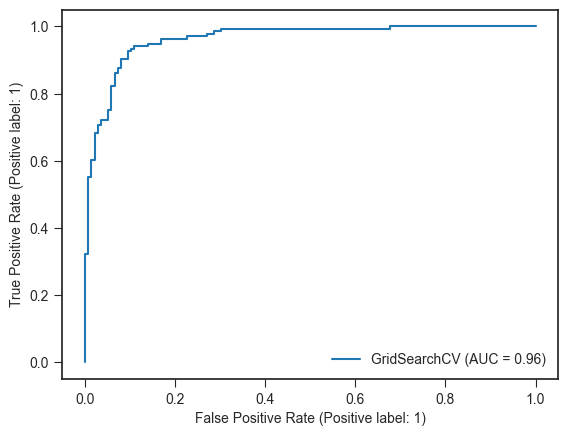

In [ ]:
metrics.plot_roc_curve(model_lr, X_test, y_test)  
plt.show() 

## Plotting ROC curves for the three models

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [ ]:
pred_prob_rf=model_rf.predict_proba(X_test)[:,1]
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob_rf, pos_label=1)
# AUC score that summarizes the ROC curve
roc_auc1 = auc(fpr1, tpr1)

In [ ]:
pred_prob_svm=model_svm.predict_proba(X_test)[:,1]
fpr2, tpr2, threshold2 = roc_curve(y_test, pred_prob_svm, pos_label=1)
# AUC score that summarizes the ROC curve
roc_auc2 = auc(fpr2, tpr2)

In [ ]:
pred_prob_lr=model_lr.predict_proba(X_test)[:,1]
fpr3, tpr3, threshold3 = roc_curve(y_test, pred_prob_lr, pos_label=1)
roc_auc3 = auc(fpr3, tpr3)

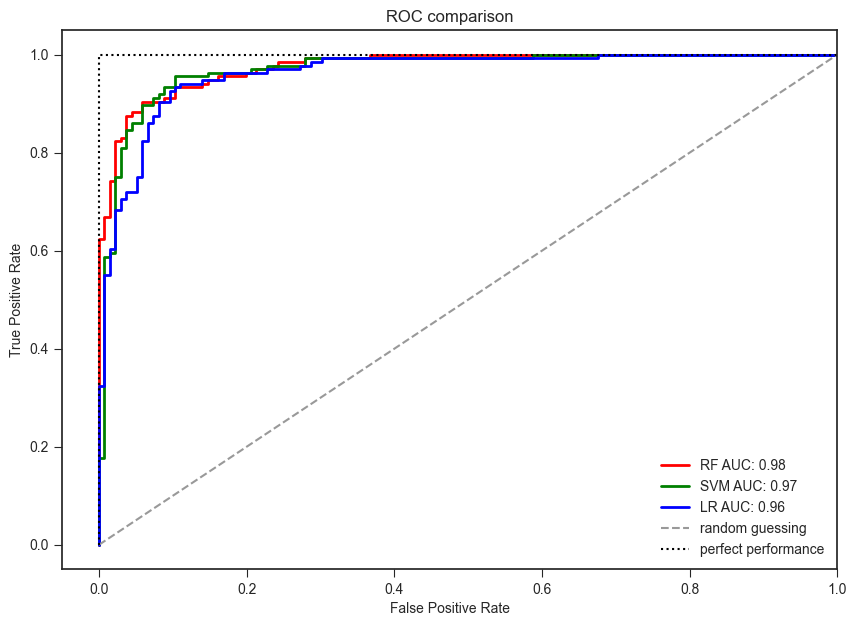

In [ ]:
# AUC score that summarizes the ROC curve
f, ax = plt.subplots(figsize=(10,7))
plt.plot(fpr1,tpr1, color ='red', lw=2, label= 'RF AUC: {:.2f}'.format(roc_auc1))
plt.plot(fpr2,tpr2, color ='green', lw=2, label='SVM AUC: {:.2f}'.format(roc_auc2))
plt.plot(fpr3,tpr3, color ='blue', lw=2, label='LR AUC: {:.2f}'.format(roc_auc3))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':',
         color = 'black', 
         label = 'perfect performance')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC comparison')
plt.legend(loc="lower right")

plt.savefig(r'C:\Users\aageen17\Desktop\figures\AUC.png', bbox_inches='tight', dpi=600)
plt.show()




## External Validation on the dataset outside of our AOI

Reading the data (landslide absence and presence points). The data is unseen by the models, as it comes outside of the AOI, and it has not earlier been used for training or testing

In [ ]:
external_val_data=pd.read_csv(r"C:\Users\aageen17\Desktop\external_validation\sample_points_external_validation.csv")

dropping the columns with climate variables

In [ ]:
external_val_data= external_val_data.drop(columns=['average_temp_ref', 'cloudburst_ref', 'groundwater_ref', 'rain_average_ref', 'rain_max_day_ref'])

In [ ]:
external_val_data.head()

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,slope_std,distance_coast,distance_streams,soil,geomorphology,underground,prequaternary,class
0,49.812370,0.083854,-0.003757,0.129422,0.260900,0.996409,-0.084667,0.260900,300.0,300.0,13.0,7.0,2.0,6.0,0
1,49.604942,0.046702,-0.015270,0.073316,0.098046,-0.840527,-0.541769,0.098046,300.0,300.0,15.0,7.0,2.0,3.0,0
2,5.504304,0.015311,0.001757,0.025309,0.187640,0.305586,0.952165,0.187640,300.0,170.0,15.0,7.0,3.0,5.0,0
3,14.678636,0.020014,0.082338,0.082340,1.015810,0.167411,0.985887,1.015810,300.0,300.0,15.0,7.0,2.0,3.0,0
4,49.577496,0.015639,0.011391,0.023651,0.299227,0.997049,0.076766,0.299227,300.0,300.0,13.0,1.0,2.0,7.0,0


In [ ]:
external_val_data.describe()

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,slope_std,distance_coast,distance_streams,soil,geomorphology,underground,prequaternary,class
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,533.000000,531.000000,536.000000,536.000000,536.000000
mean,20.135290,0.244451,-0.008599,0.423928,2.318799,0.243170,-0.132470,2.318799,157.149254,260.222015,13.996248,5.446328,1.910448,4.205224,0.500000
std,18.428207,0.233691,0.133181,0.425307,2.283054,0.651744,0.707301,2.283054,138.969425,78.695492,2.842346,2.014673,0.465042,1.153155,0.500467
min,0.402274,0.001110,-0.515859,0.002401,0.032800,-0.999929,-0.999999,0.032800,4.000000,6.000000,1.000000,1.000000,1.000000,2.000000,0.000000
25%,5.465367,0.038828,-0.052992,0.062701,0.328095,-0.309631,-0.836977,0.328095,17.000000,274.000000,15.000000,4.000000,2.000000,3.000000,0.000000
50%,10.072013,0.147655,-0.000764,0.241882,1.674350,0.406322,-0.270108,1.674350,94.000000,300.000000,15.000000,7.000000,2.000000,4.000000,0.500000
75%,37.256358,0.438952,0.027826,0.734017,3.757548,0.817782,0.565536,3.757548,300.000000,300.000000,15.000000,7.000000,2.000000,5.000000,1.000000
max,75.153809,0.943547,0.436441,2.166438,10.612181,0.999994,0.999984,10.612181,300.000000,300.000000,19.000000,10.000000,3.000000,7.000000,1.000000


In [ ]:
external_val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dem_elevation     536 non-null    float64
 1   TWI               536 non-null    float64
 2   TPI               536 non-null    float64
 3   TRI               536 non-null    float64
 4   SPI               536 non-null    float64
 5   easterness        536 non-null    float64
 6   northerness       536 non-null    float64
 7   slope_std         536 non-null    float64
 8   distance_coast    536 non-null    float64
 9   distance_streams  536 non-null    float64
 10  soil              533 non-null    float64
 11  geomorphology     531 non-null    float64
 12  underground       536 non-null    float64
 13  prequaternary     536 non-null    float64
 14  class             536 non-null    int64  
dtypes: float64(14), int64(1)
memory usage: 62.9 KB


dropping null values

In [ ]:
external_val_data=external_val_data.dropna()

In [ ]:
external_val_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528 entries, 0 to 535
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dem_elevation     528 non-null    float64
 1   TWI               528 non-null    float64
 2   TPI               528 non-null    float64
 3   TRI               528 non-null    float64
 4   SPI               528 non-null    float64
 5   easterness        528 non-null    float64
 6   northerness       528 non-null    float64
 7   slope_std         528 non-null    float64
 8   distance_coast    528 non-null    float64
 9   distance_streams  528 non-null    float64
 10  soil              528 non-null    float64
 11  geomorphology     528 non-null    float64
 12  underground       528 non-null    float64
 13  prequaternary     528 non-null    float64
 14  class             528 non-null    int64  
dtypes: float64(14), int64(1)
memory usage: 66.0 KB


In [ ]:
external_val_data['class'].value_counts()

0    268
1    260
Name: class, dtype: int64

Dividing the data into variables and the labels

In [ ]:
X_val = external_val_data.iloc[:, 0:-1]

In [ ]:
X_val.head()

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,slope_std,distance_coast,distance_streams,soil,geomorphology,underground,prequaternary
0,49.812370,0.083854,-0.003757,0.129422,0.260900,0.996409,-0.084667,0.260900,300.0,300.0,13.0,7.0,2.0,6.0
1,49.604942,0.046702,-0.015270,0.073316,0.098046,-0.840527,-0.541769,0.098046,300.0,300.0,15.0,7.0,2.0,3.0
2,5.504304,0.015311,0.001757,0.025309,0.187640,0.305586,0.952165,0.187640,300.0,170.0,15.0,7.0,3.0,5.0
3,14.678636,0.020014,0.082338,0.082340,1.015810,0.167411,0.985887,1.015810,300.0,300.0,15.0,7.0,2.0,3.0
4,49.577496,0.015639,0.011391,0.023651,0.299227,0.997049,0.076766,0.299227,300.0,300.0,13.0,1.0,2.0,7.0


In [ ]:
y_val = external_val_data["class"]

## SVM

Predicting the classes of the external validation data with our trained SVM classifier

In [ ]:
y_pred_svm_val = model_svm.predict(X_val)

Printing overall accuracy

In [ ]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_val, y_pred_svm_val),4)

0.7254

Plotting confusion matrix

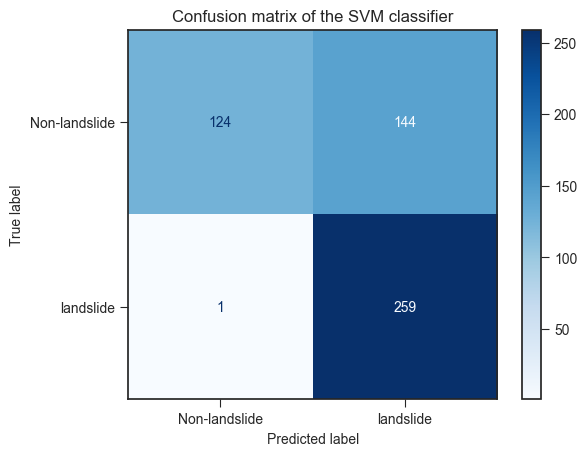

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_svm_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the SVM classifier')
plt.show()

Repeating the process with RF and LR

## Random Forest

In [ ]:
y_pred_rf_val = model_rf.predict(X_val)

In [ ]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_val, y_pred_rf_val), 4)

0.9394

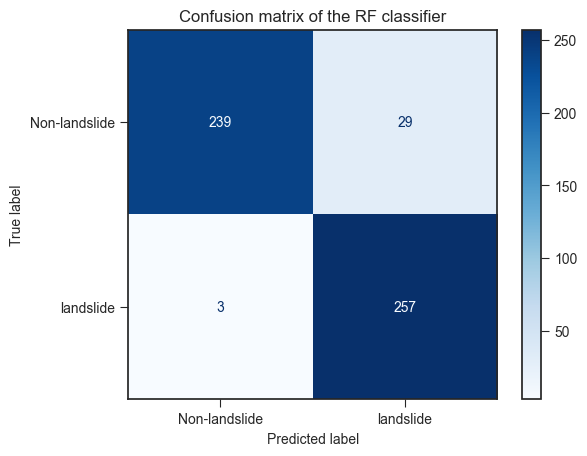

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_rf_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the RF classifier')
plt.show()

## Logistic Regression

In [ ]:
y_pred_lr_val = model_lr.predict(X_val)

In [ ]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_val, y_pred_lr_val), 4)

0.4924

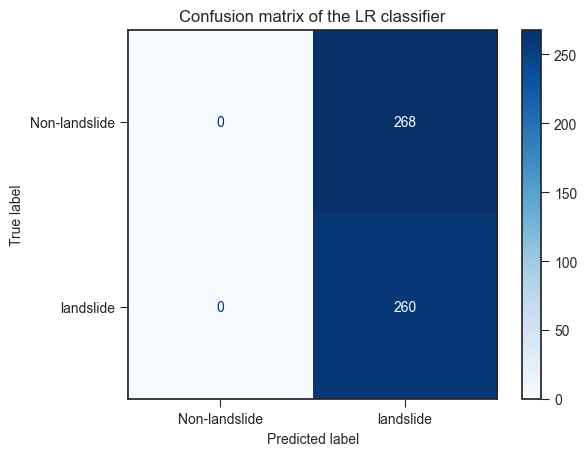

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_lr_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the LR classifier')
plt.show()

## Making susceptibility maps with our trained classifiers

Predicting probability with trained RF classifier

In [ ]:
result_rf = stack.predict_proba(model_rf)

Plotting probabilities

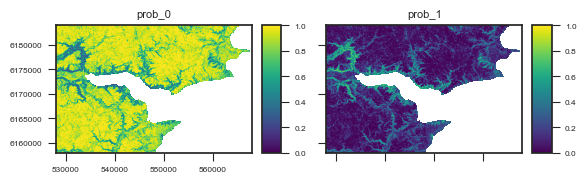

In [ ]:
result_rf.plot()
plt.show()

Saving the result as a .tif file

In [ ]:
result_rf.write(r"probability_rf_without_climate_variables.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_rf_without_climate_variables.tif,...
2        rows                                              13000
3        cols                                              19976
4         res                          (2.0000000000000444, 2.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


Repeating it with LR

In [ ]:
result_lr = stack.predict_proba(estimator=model_lr)

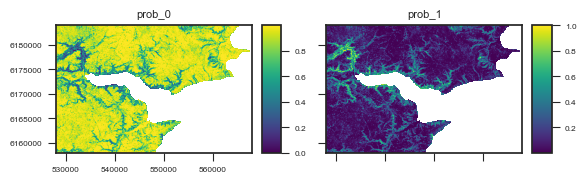

In [ ]:
result_lr.plot()
plt.show()

In [ ]:
result_lr.write(r"probability_lr_without_climate_variables.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_lr_without_climate_variables.tif,...
2        rows                                              13000
3        cols                                              19976
4         res                          (2.0000000000000444, 2.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


and SVM

In [ ]:
result_svm = stack.predict_proba(estimator=model_svm)

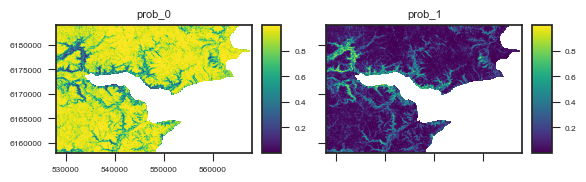

In [ ]:
result_svm.plot()
plt.show()

In [ ]:
result_svm.write(r"probability_svm_without_climate_variables.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_svm_without_climate_variables.tif...
2        rows                                              13000
3        cols                                              19976
4         res                          (2.0000000000000444, 2.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


The end